In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import zuko

np.random.seed(100)
print(torch.cuda.is_available())

True


In [2]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [3]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        self.data = dataframe
        if rows is not None:
            self.data = self.data.iloc[:rows]
        self.target = self.data[target_variables].values
        self.context = self.data[context_variables].values
        self.weights = self.data[['weight']].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)
            self.weights = torch.tensor(self.weights, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx], self.weights[idx]

In [4]:
input_dir = "./samples"
df = pd.read_parquet(os.path.join(input_dir, "train.parquet"))
df_target = pd.read_parquet(os.path.join(input_dir, "train_target.parquet"))
df_test = pd.read_parquet(os.path.join(input_dir, "test.parquet"))
df_target_test = pd.read_parquet(os.path.join(input_dir, "test_target.parquet"))

context_vars = ['a', 'b']
input_vars = ['x', 'y']
rows = 100000
rows_test = 100000
batch_size = 1000
print(len(df), len(df_test))
mc_dataset_train = MyDataset(df, context_vars, input_vars, device=device, rows=rows)
mc_loader_train = DataLoader(mc_dataset_train, batch_size=batch_size)
data_dataset_train = MyDataset(df_target, context_vars, input_vars, device=device, rows=rows)
data_loader_train = DataLoader(data_dataset_train, batch_size=batch_size)
mc_dataset_test = MyDataset(df_test, context_vars, input_vars, device=device, rows=rows_test)
mc_loader_test = DataLoader(mc_dataset_test, batch_size=batch_size)
data_dataset_test = MyDataset(df_target_test, context_vars, input_vars, device=device, rows=rows_test)
data_loader_test = DataLoader(data_dataset_test, batch_size=batch_size)

1400000 600000


# Train bases

In [5]:
ninput = len(input_vars)
ncontext = len(context_vars)

epochs = 20
plot_every = 10

def make_base_flow_and_train(loader, test_loader, df_test):
    flow = zuko.flows.NSF(
        features=ninput,
        context=ncontext,
        transforms=12,
        bins=12,
        hidden_features=[256]*2
    )
    
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for ab, xy, weights in loader:
            loss = -flow(ab).log_prob(xy) * weights
            loss = loss.mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for ab, xy, weights in test_loader:
            with torch.no_grad():
                loss = -flow(ab).log_prob(xy) * weights
                loss = loss.mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, x, y = df_test['a'].values, df_test['b'].values, df_test['x'].values, df_test['y'].values
            xy_sample = flow(torch.tensor(df_test[['a', 'b']].values, dtype=torch.float32).to(device)).sample().reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            x_min = min(x.min(), x_sample.min())
            x_max = max(x.max(), x_sample.max())
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            y_min = min(y.min(), y_sample.min())
            y_max = max(y.max(), y_sample.max())
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
    
    return flow

0
testing
plotting


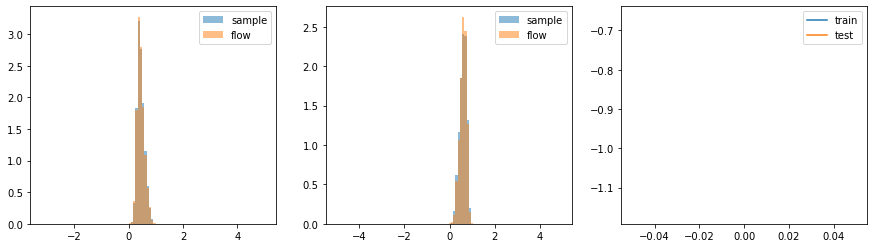

1
testing
2
testing
3
testing
4
testing
5
testing
6
testing
7
testing
8
testing
9
testing
10
testing
plotting


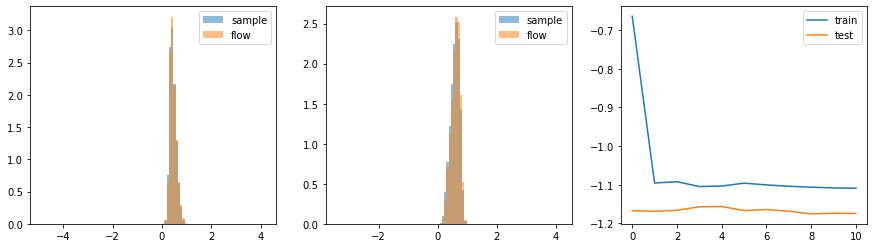

11
testing
12
testing
13
testing
14
testing
15
testing
16
testing
17
testing
18
testing
19
testing
20
testing
plotting


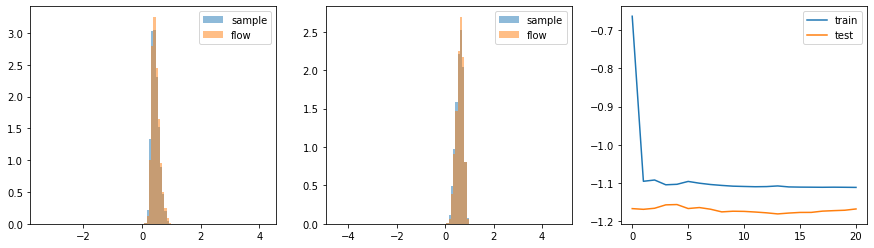

In [6]:
flow_mc = make_base_flow_and_train(mc_loader_train, mc_loader_test, df_test)

0
testing
plotting


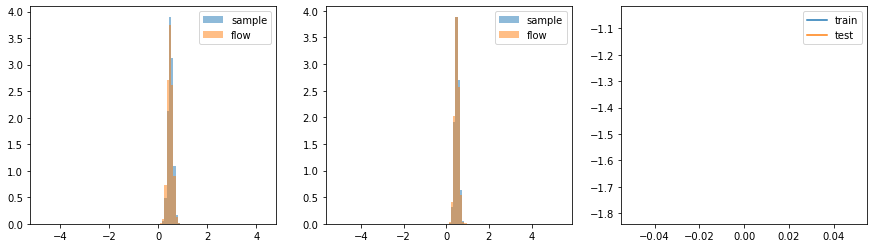

1
testing
2
testing
3
testing
4
testing
5
testing
6
testing
7
testing
8
testing
9
testing
10
testing
plotting


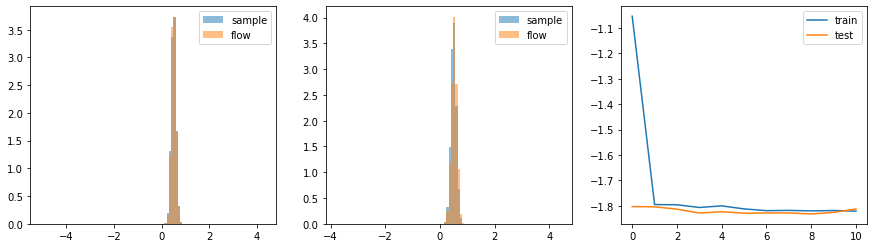

11
testing
12
testing
13
testing
14
testing
15
testing
16
testing
17
testing
18
testing
19
testing
20
testing
plotting


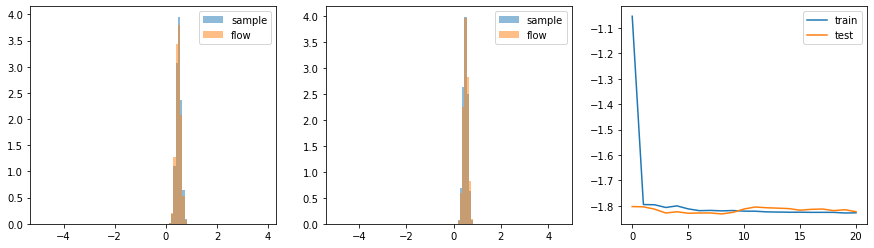

In [7]:
flow_data = make_base_flow_and_train(data_loader_train, data_loader_test, df_target_test)

# Train top

In [8]:
class BasePenalty(nn.Module):
    def __init__(self, weight=0.0):
        super(BasePenalty, self).__init__()
        self.register_buffer('weight', torch.Tensor([weight]))

    def penalty_function(self, inputs, outputs):
        return 0

    def forward(self, inputs, outputs):
        """Return calculation of distance penalty with gradients"""
        return self.weight * self.penalty_function(inputs, outputs)

class WrapPytorchPenalty(BasePenalty):
    """Wrapper class for distance penalty from any predefined pytorch method for FlowForFlow model"""
    def __init__(self, pytorch_method, weight):
        """Create a distance penalty class from a pytorch method
        Inputs
            pytorch_method: PyTorch function for distance penalty
            weight: relative weight for penalty term in total loss"""
        super(WrapPytorchPenalty, self).__init__(weight)
        self.torch_penalty = pytorch_method(reduction='none')

    def penalty_function(self, inputs, outputs):
        return self.torch_penalty(outputs, inputs).sum(-1)

class LOnePenalty(WrapPytorchPenalty):
    """L1 distance penalty clas for FlowForFlow models"""
    def __init__(self, weight):
        """Create a L1 distance penalty term
        Inputs
            weight: relative weight for penalty term in total loss"""
        super(LOnePenalty, self).__init__(nn.L1Loss, weight)
        
class AnnealedPenalty(BasePenalty):
    """Annealing weight for distance penalty class"""
    def __init__(self, penalty, n_steps=None, min_weight=0):
        """Create an annealing distance penalty term
        Inputs
            penalty: Distance penalty class
            n_steps: How many steps in the training of the flow
            min_weight minimum value for weight of distance penalty class"""
        super(AnnealedPenalty, self).__init__()
        self.min_weight = min_weight
        self.penalty_to_wrap = penalty
        self.initial_weight = deepcopy(self.penalty_to_wrap.weight)
        self.n_steps = n_steps
        self.pi = torch.tensor(np.pi, dtype=torch.float32)
        self.step = 0

    def set_n_steps(self, n_steps):
        if self.n_steps is None:
            self.n_steps = n_steps

    def update_weight(self):
        # TODO currently following a cosine schedule, but this should be possible to set/configure.
        self.penalty_to_wrap.weight = self.min_weight + 0.5 * (self.initial_weight - self.min_weight) * (
                    1 + (self.pi * self.step / self.n_steps).cos())
        self.step += 1

    def penalty_function(self, inputs, outputs):
        self.update_weight()
        return self.penalty_to_wrap.penalty_function(inputs, outputs)    

def set_penalty(f4flow, penalty, weight, anneal=False):
    if penalty not in ["None", None]:
        if penalty == "l1":
            penalty_constr = LOnePenalty
        penalty = penalty_constr(weight)
        if anneal:
            penalty = AnnealedPenalty(penalty)
        f4flow.add_penalty(penalty)

class FFFZuko(zuko.flows.core.Flow):
    def __init__(self, transform, flow_mc, flow_data):
        super().__init__(transform.transforms, transform.base)
        self._transform = transform
        self.flow_mc = flow_mc
        self.flow_data = flow_data

    def add_penalty(self, penalty_object):
        """Add a distance penaly object to the class."""
        assert isinstance(penalty_object, BasePenalty)
        self.distance_object = penalty_object

    def base_flow_log_prob(
        self, inputs, context, inverse=False
    ):
        if inverse:
            fnc = self.flow_mc(context).log_prob
        else:
            fnc = self.flow_data(context).log_prob
        logprob = fnc(inputs)
        return logprob

    def transform(self, inputs, context, inverse=False):
        transform = self._transform(context).transform.inv if inverse else self._transform(context).transform
        y = transform(inputs)
        logabsdet = transform.log_abs_det_jacobian(inputs, inputs)

        return y, logabsdet

    def log_prob(self, inputs, context, inverse=False):
        converted_input, logabsdet = self.transform(
            inputs, context, inverse=inverse
        )
        log_prob = self.base_flow_log_prob(
            converted_input, context, inverse=inverse
        )
        dist_pen = -self.distance_object(converted_input, inputs)

        return log_prob, logabsdet, dist_pen

In [9]:
# freeze base flows
for param in flow_data.parameters():
    param.requires_grad = False

for param in flow_mc.parameters():
    param.requires_grad = False

fffmodel = FFFZuko(
   zuko.flows.NSF(
        features=ninput,
        context=ncontext,
        transforms=12,
        bins=12,
        hidden_features=[256]*2
    ),
    flow_mc,
    flow_data
)

set_penalty(
    fffmodel,
    "l1",
    0.1,
    False
)
fffmodel = fffmodel.to(device)

In [10]:
optimizer = torch.optim.Adam(
    fffmodel.parameters(),
    lr=0.001,
    #betas=(cfg.optimizer.beta1, cfg.optimizer.beta2),
    #weight_decay=cfg.optimizer.weight_decay,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

0


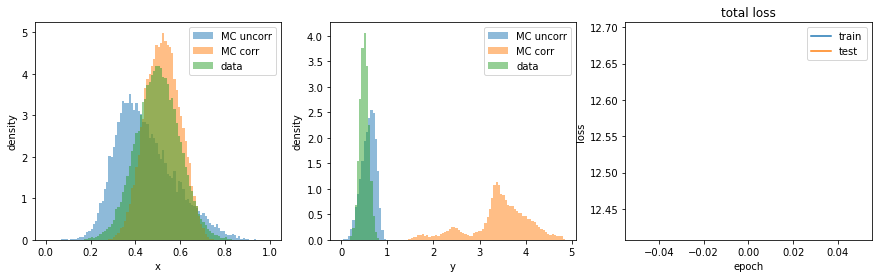

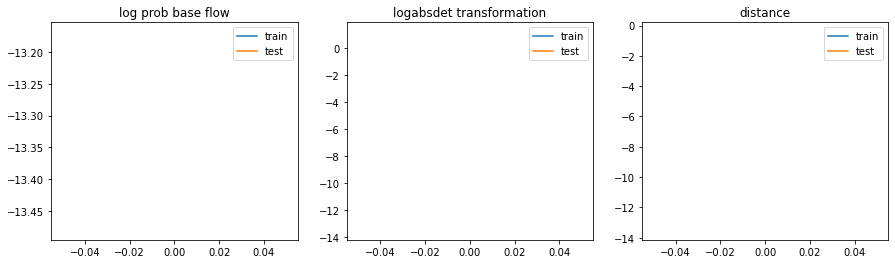

1
2
3
4


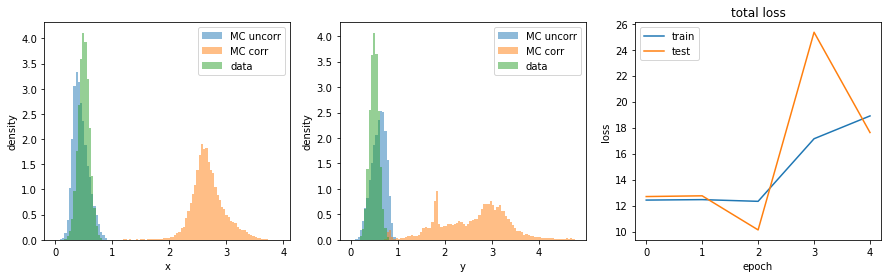

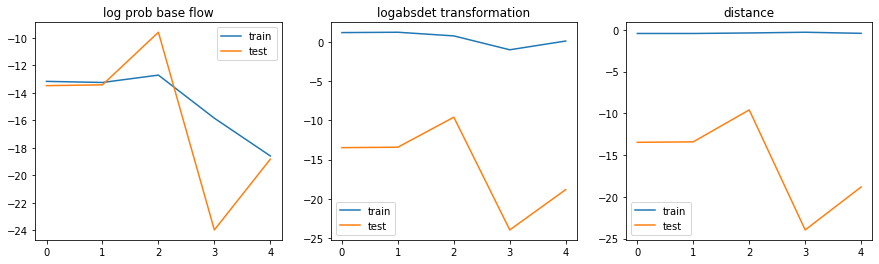

5
6
7
8


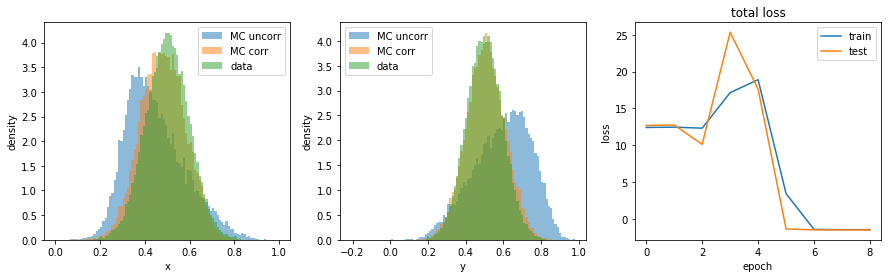

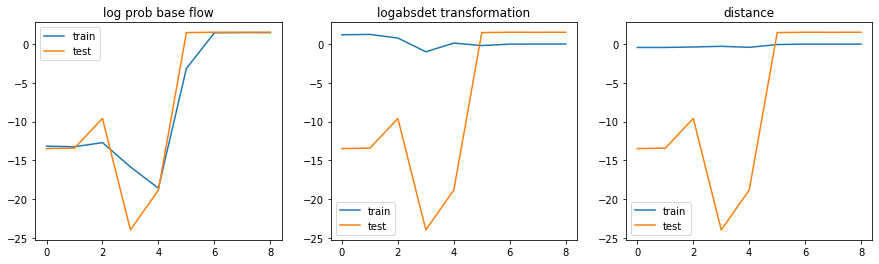

9
10
11
12


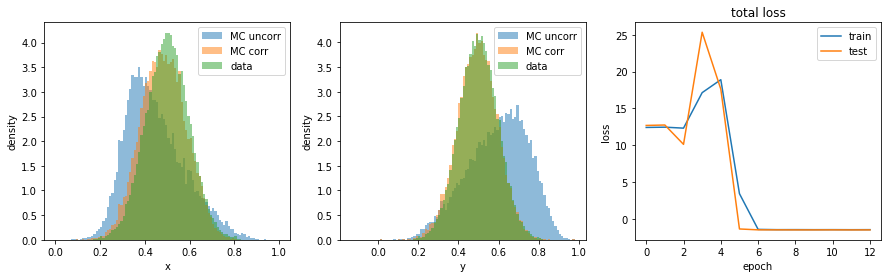

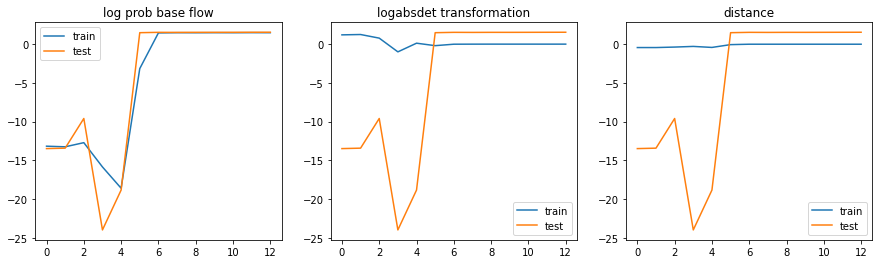

13
14
15
16


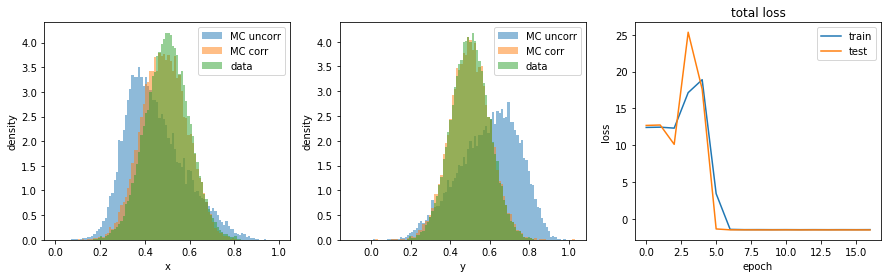

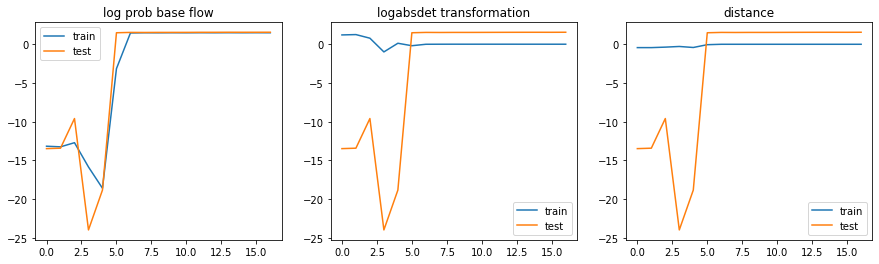

17
18
19
20


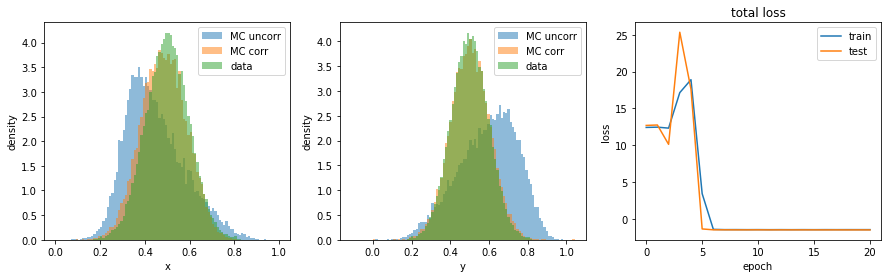

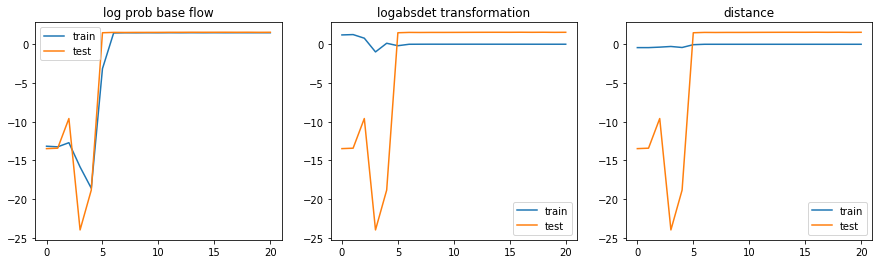

21
22
23
24


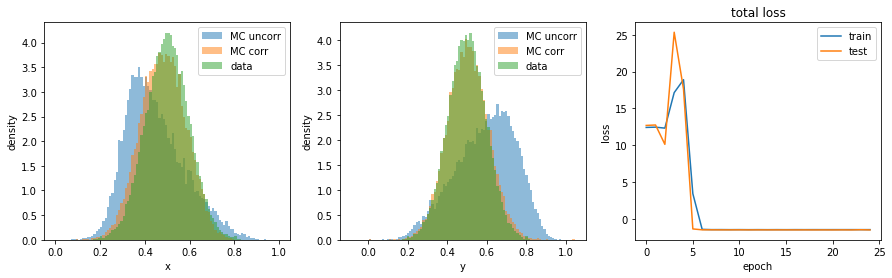

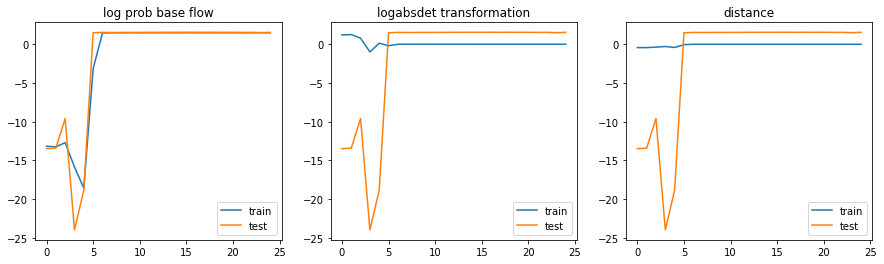

25
26
27
28


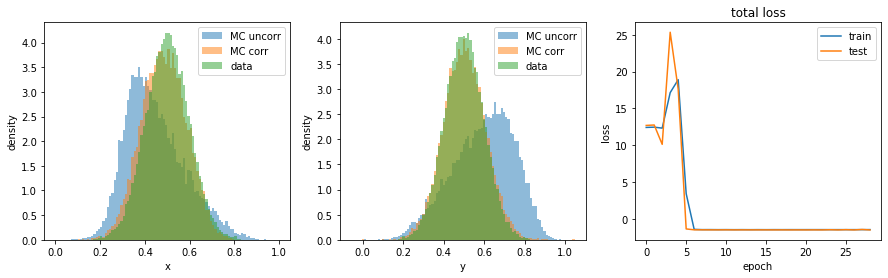

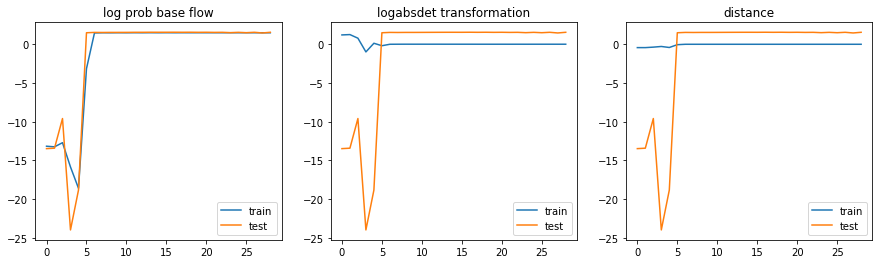

29
30
31
32


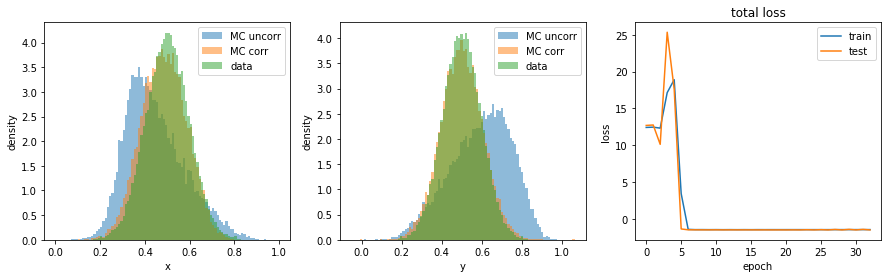

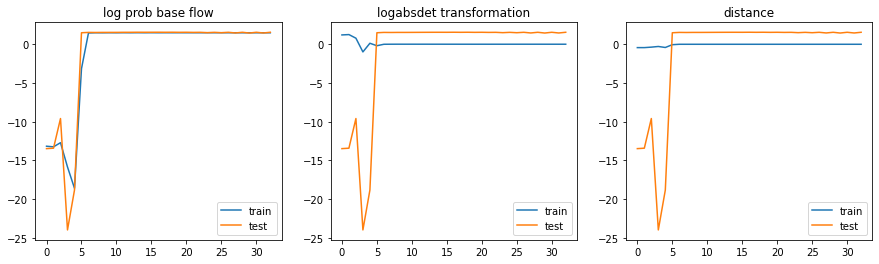

33
34
35
36


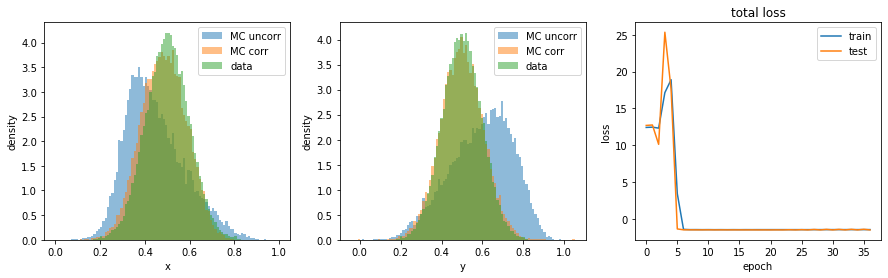

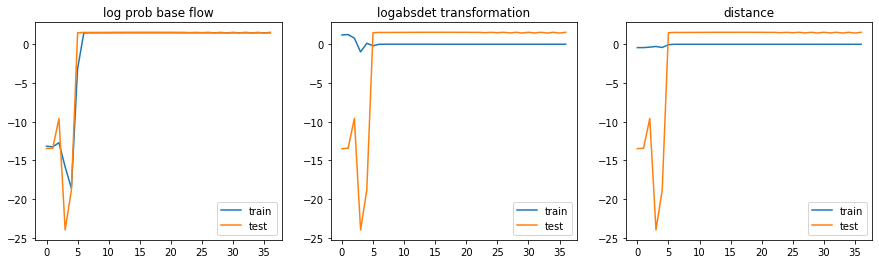

37
38
39
40


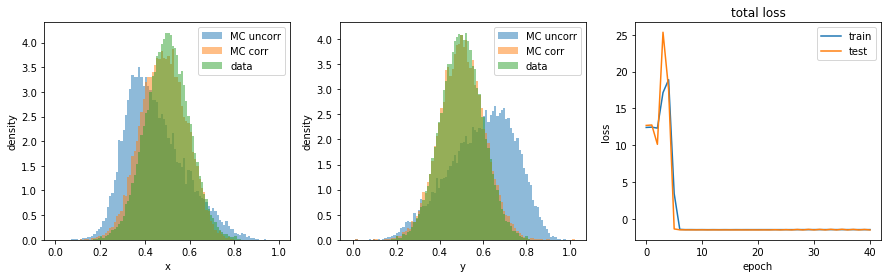

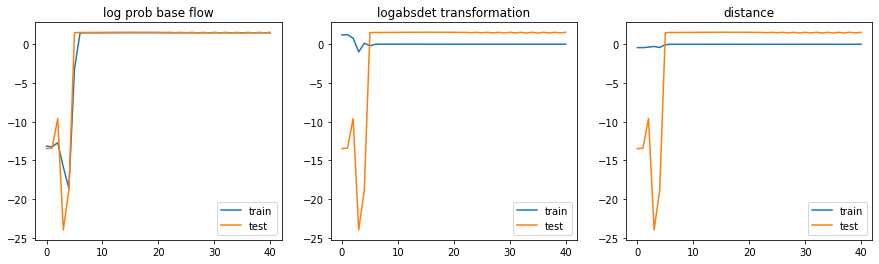

41
42
43
44


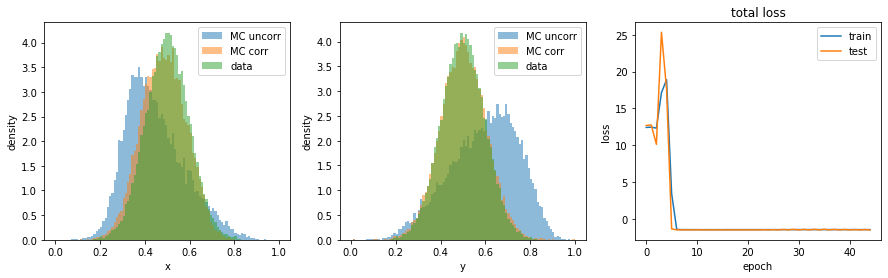

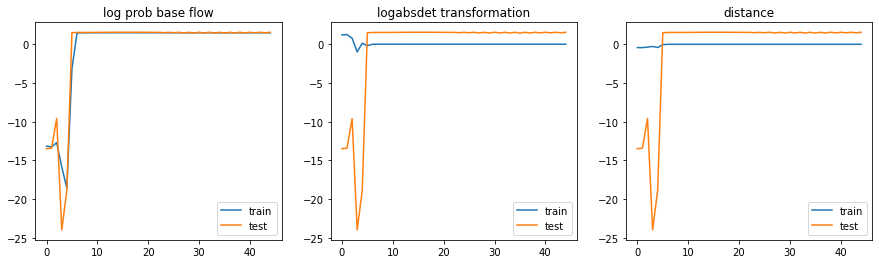

45
46
47
48


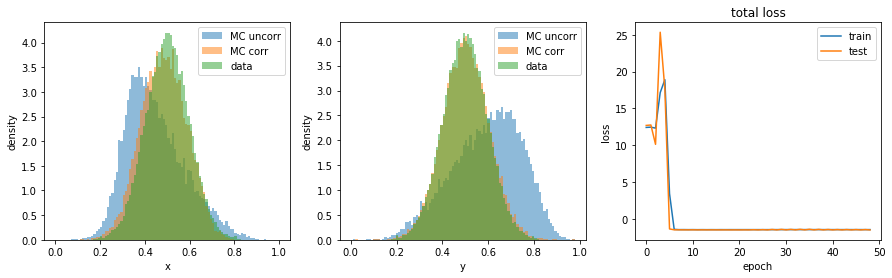

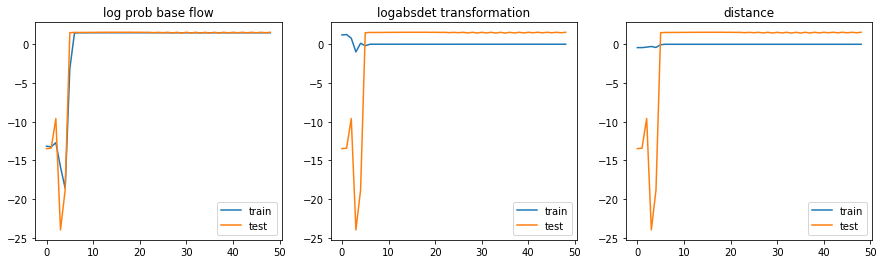

49
50
51
52


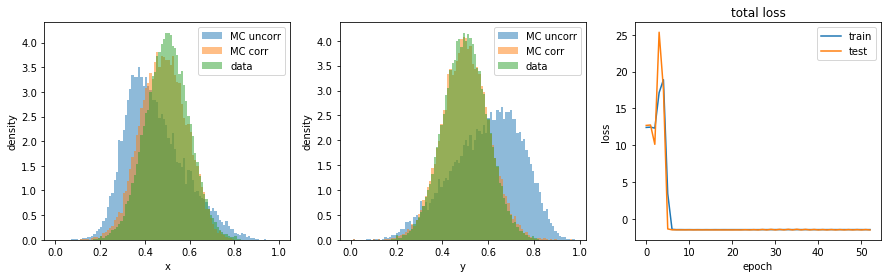

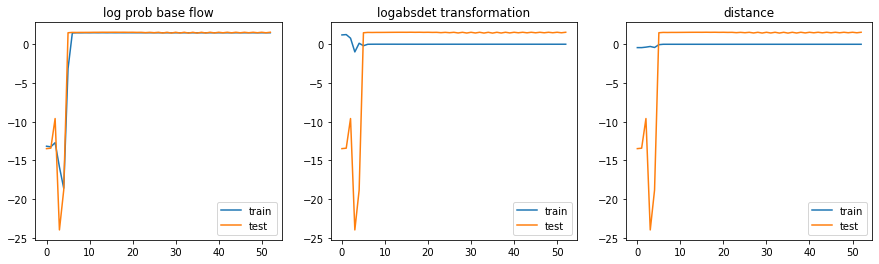

53
54
55
56


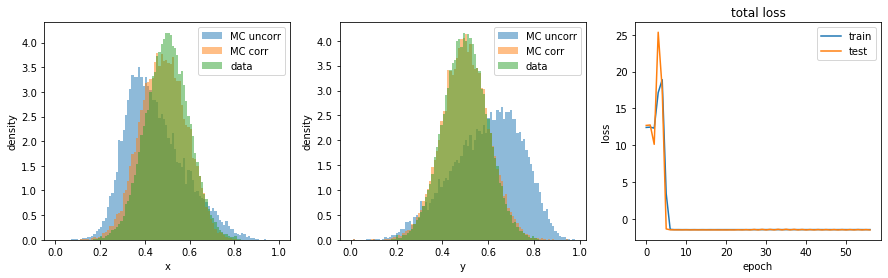

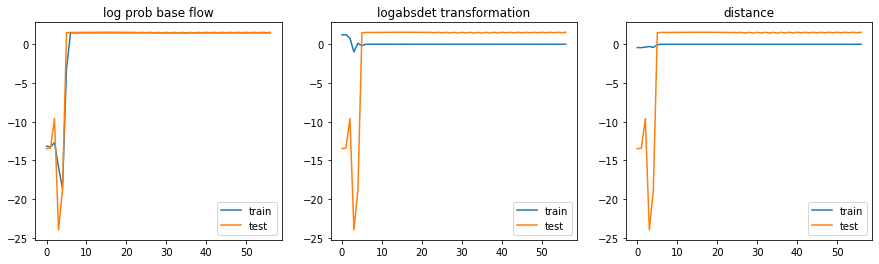

57
58
59
60


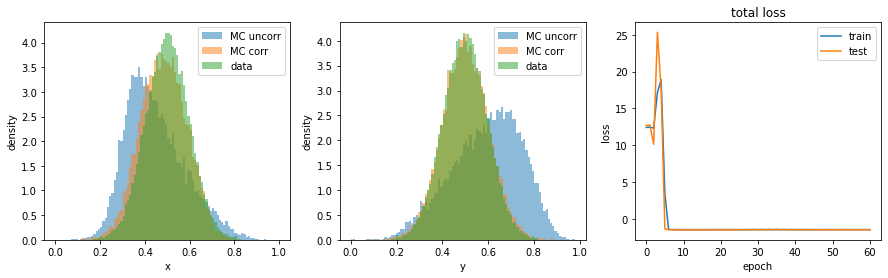

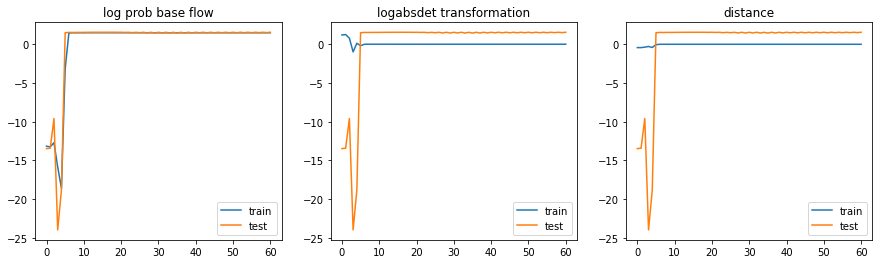

61
62
63
64


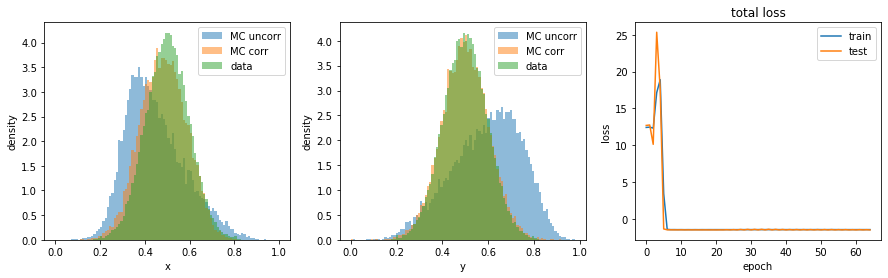

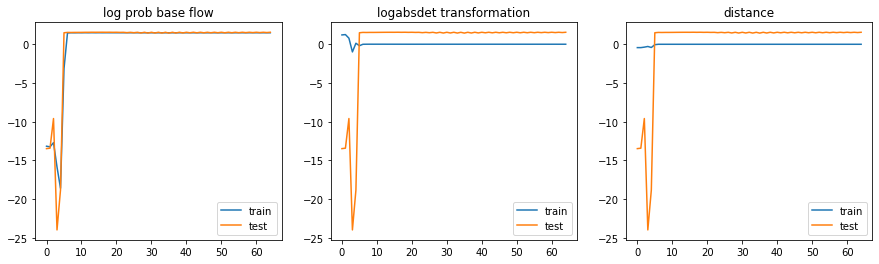

65
66
67
68


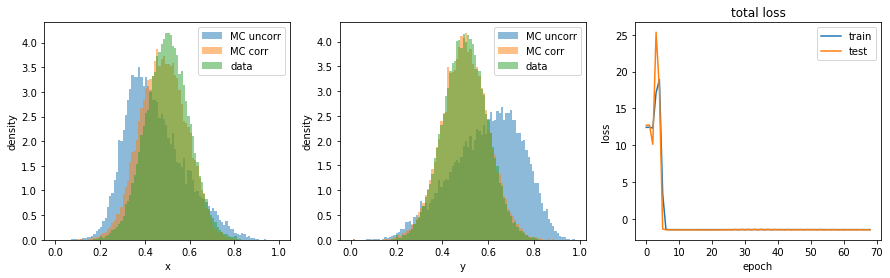

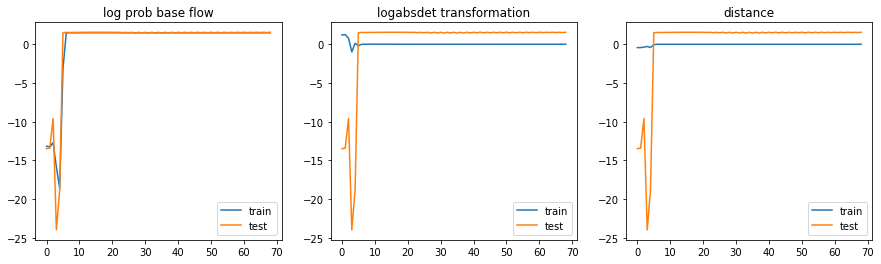

69
70
71
72


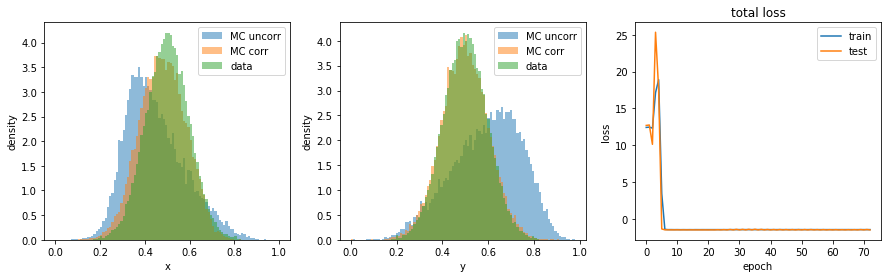

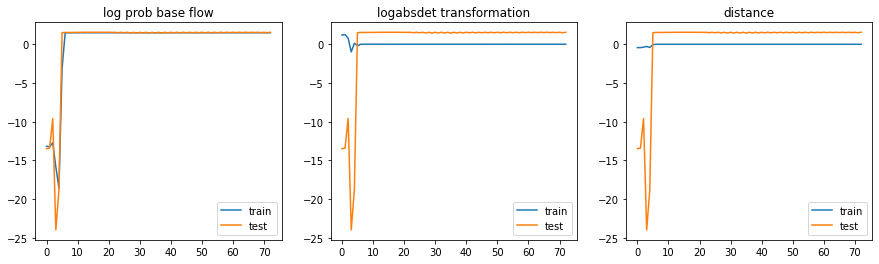

73
74
75
76


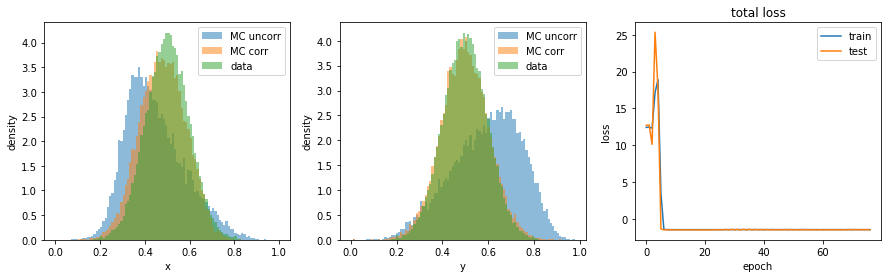

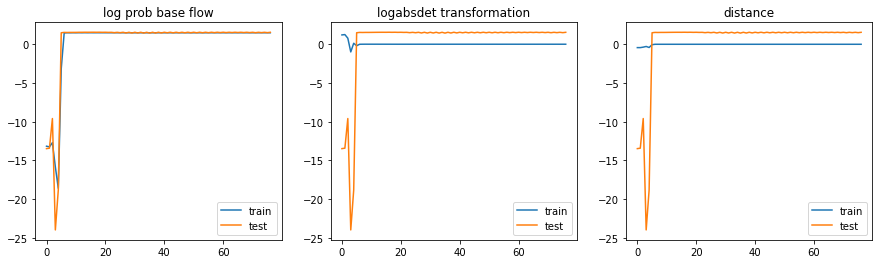

77
78
79
80


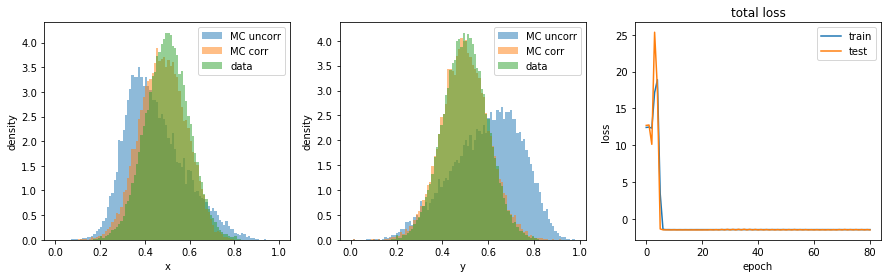

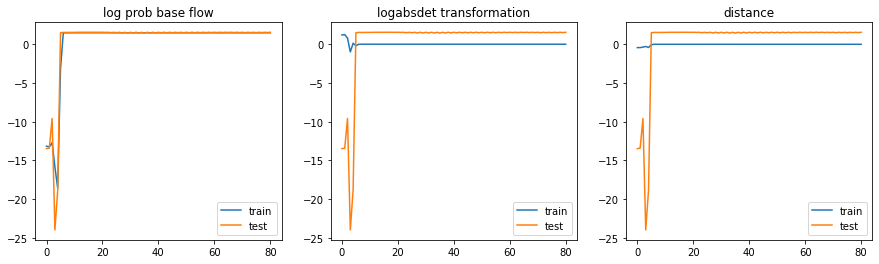

81
82
83
84


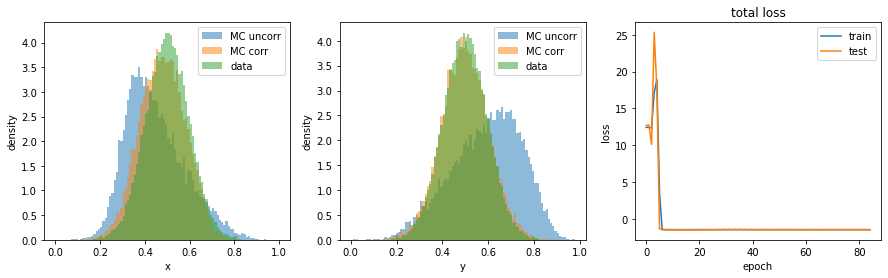

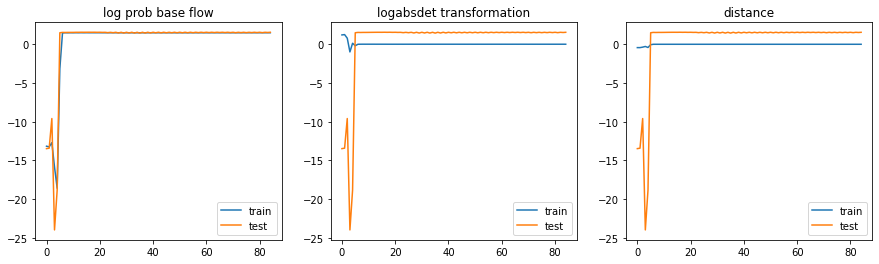

85
86
87
88


In [ ]:
epochs = 200
batch_size = 512
plot_every = 4

train_history, test_history = [], []
train_history1, test_history1 = [], []
train_history2, test_history2 = [], []
train_history3, test_history3 = [], []
for epoch in range(epochs):
    print(epoch)
    epoch_is_even = epoch % 2 == 0
    train_losses, test_losses = [], []
    train_losses1, test_losses1 = [], []
    train_losses2, test_losses2 = [], []
    train_losses3, test_losses3 = [], []
    # train
    for i, (data, mc) in enumerate(zip(data_loader_train, mc_loader_train)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy, weights = mc
        else:
            inverse = True
            ab, xy, weights = data
        optimizer.zero_grad()
        loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
        loss1 = loss1 * weights
        loss2 = loss2 * weights
        loss3 = loss3 * weights
        loss = - (loss1 + loss2 + loss3)
        loss = loss.mean()
        loss1 = loss1.mean()
        loss2 = loss2.mean()
        loss3 = loss3.mean()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        train_losses1.append(loss1.item())
        train_losses2.append(loss2.item())
        train_losses3.append(loss3.item())
    train_history.append(np.mean(train_losses))
    train_history1.append(np.mean(train_losses1))
    train_history2.append(np.mean(train_losses2))
    train_history3.append(np.mean(train_losses3))
    
    # test
    for i, (data, mc) in enumerate(zip(data_loader_test, mc_loader_test)):
        if i % 2 == 0 + int(epoch_is_even):
            inverse = False
            ab, xy, weights = mc
        else:
            inverse = True
            ab, xy, weights = data
        with torch.no_grad():
            loss1, loss2, loss3 = fffmodel.log_prob(xy, ab, inverse=inverse)
            loss1 = loss1 * weights
            loss2 = loss2 * weights
            loss3 = loss3 * weights
            loss = - (loss1 + loss2 + loss3)
            loss = loss.mean()
            loss1 = loss1.mean()
            loss2 = loss2.mean()
            loss3 = loss3.mean()
            test_losses.append(loss.item())
            test_losses1.append(loss1.item())
            test_losses2.append(loss2.item())
            test_losses3.append(loss3.item())
    test_history.append(np.mean(test_losses))
    test_history1.append(np.mean(test_losses1))
    test_history2.append(np.mean(test_losses2))
    test_history3.append(np.mean(test_losses3))

    if epoch % plot_every == 0:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        mc_lst, mc_corr_lst = [], []
        mc_weights_lst = []
        for ab, xy, weights in mc_loader_test:
            xy_corr = fffmodel.transform(xy, ab, inverse=False)[0]
            xy_corr = xy_corr.detach().cpu().numpy()
            xy = xy.detach().cpu().numpy()
            mc_corr_lst.append(xy_corr)
            mc_lst.append(xy)
            weights = weights.detach().cpu().numpy()
            mc_weights_lst.append(weights)
        mc = np.concatenate(mc_lst, axis=0)
        mc_corr = np.concatenate(mc_corr_lst, axis=0)
        mc = pd.DataFrame(mc, columns=input_vars)
        mc_corr = pd.DataFrame(mc_corr, columns=input_vars)
        weights = np.concatenate(mc_weights_lst, axis=0)
        data = data_dataset_test.data.sample(len(mc))
        
        # plot
        x_mc_uncorr, y_mc_uncorr = mc['x'].values, mc['y'].values
        x_mc_corr, y_mc_corr = mc_corr['x'].values, mc_corr['y'].values
        x_data, y_data = data['x'].values, data['y'].values
        
        x_min = min(x_mc_uncorr.min(), x_mc_corr.min(), x_data.min())
        x_max = max(x_mc_uncorr.max(), x_mc_corr.max(), x_data.max())
        ax1.hist(x_mc_uncorr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC uncorr', weights=weights)
        ax1.hist(x_mc_corr, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='MC corr', weights=weights)
        ax1.hist(x_data, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='data')
        ax1.set_xlabel('x')
        ax1.set_ylabel('density')
        ax1.legend()
        y_min = min(y_mc_uncorr.min(), y_mc_corr.min(), y_data.min())
        y_max = max(y_mc_uncorr.max(), y_mc_corr.max(), y_data.max())
        ax2.hist(y_mc_uncorr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC uncorr', weights=weights)
        ax2.hist(y_mc_corr, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='MC corr', weights=weights)
        ax2.hist(y_data, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='data')
        ax2.set_xlabel('y')
        ax2.set_ylabel('density')
        ax2.legend()
        ax3.plot(train_history, label='train')
        ax3.plot(test_history, label='test')
        ax3.set_xlabel('epoch')
        ax3.set_ylabel('loss')
        ax3.set_title('total loss')
        ax3.legend()
        plt.show()
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
        ax1.plot(train_history1, label='train')
        ax1.plot(test_history1, label='test')
        ax1.set_title('log prob base flow')
        ax1.legend()
        ax2.plot(train_history2, label='train')
        ax2.plot(test_history1, label='test')
        ax2.set_title('logabsdet transformation')
        ax2.legend()
        ax3.plot(train_history3, label='train')
        ax3.plot(test_history1, label='test')
        ax3.set_title('distance')
        ax3.legend()
        plt.show()